# Import

In [2]:
%pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 11.2 MB/s eta 0:00:00


In [3]:
from PIL import Image, ImageOps
import math
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms as T
import torchmetrics
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
tf.compat.v1.enable_eager_execution()
print("Libraries imported.")

Libraries imported.


## Confusion Matrix Function

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Image Processing and Dataset Creation

In [14]:
views = ["Dataset/Below_CAM"]
letters = ["A","B","C","D"]
num_views = 1
num_letters = 4
#real size (1280,720,3)
height = 1280
width = 720
depth = 3
size = (height,width)

In [331]:
try:
  del X_all
  del y_all
except:
  None
for idx_view in range(num_views):
  for idx_letter in range(num_letters):
    dir_path = views[idx_view] + "/" + letters[idx_letter]
    num_images = 0
    for image_name in os.listdir(dir_path):
      image_path = dir_path + "/" + image_name
      im = Image.open(image_path)
      #Image Processing
      im_new = im.resize(size)
      im_new = ImageOps.invert(im_new)
      #Dataset Creation
      try:
        X_all = torch.cat((X_all, torch.reshape(T.ToTensor()(im_new), (1, depth, height, width))), dim=0)
        y_all = torch.cat((y_all, torch.tensor([idx_letter])), dim = 0)
      except:
        X_all = torch.reshape(T.ToTensor()(im_new), (1, depth, height, width))
        y_all = torch.tensor([idx_letter])

## Methods for Data Augmentation

In [12]:
def data_augmentation_zoom(img_np):
  first_component = np.random.rand(1)*0.5 + 0.75
  second_component = np.random.rand(1)*0.5 + 0.75
  zoom_range = (first_component, second_component)
  img = tf.convert_to_tensor(img_np)
  img_tf = tf.numpy_function(lambda img: tf.keras.preprocessing.image.random_zoom(
      img, zoom_range, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest',
  ), [img], tf.float32)
  img_np = np.array(img_tf)
  img_torch = torch.Tensor(img_np)
  img_torch = torch.reshape(img_torch, (1, depth, height, width))
  return img_np


In [40]:
def data_augmentation_rotation(img_np):
  rg = math.floor(np.random.rand(1)*90 - 45)
  img = tf.convert_to_tensor(img_np)
  img_tf = tf.numpy_function(lambda img: tf.keras.preprocessing.image.random_rotation(
    img, rg, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.0, interpolation_order=1,
  ), [img], tf.float32)
  img_np = np.array(img_tf)
  img_torch = torch.Tensor(img_np)
  img_torch = torch.reshape(img_torch, (1, depth, height, width))
  return img_torch

In [58]:
def data_augmentation_shear(img_np):
  intensity = math.floor(np.random.rand(1)*45)
  img = tf.convert_to_tensor(img_np)
  img_tf = tf.numpy_function(lambda img: tf.keras.preprocessing.image.random_shear(
      img, intensity, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.0, interpolation_order=1
  ), [img], tf.float32)
  img_np = np.array(img_tf)
  img_torch = torch.Tensor(img_np)
  img_torch = torch.reshape(img_torch, (1, depth, height, width))
  return img_torch

## Data Augmentation

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=16)

In [350]:
# Data Augmentation for Training Set
for i in range(X_train.shape[0]):
  for j in range(3):
    X_train = torch.cat((X_train, data_augmentation_rotation(X_train[i].numpy())), dim=0)
    y_train = torch.cat((y_train, torch.tensor([y_train[i]])), dim = 0)
  #X_train = torch.cat((X_train, data_augmentation_zoom(X_train[i].numpy())), dim=0) it is not useful
  #y_train = torch.cat((y_train, torch.tensor([y_train[i]])), dim = 0)
  #X_train = torch.cat((X_train, data_augmentation_shear(X_train[i].numpy())), dim=0) It is not useful
  #y_train = torch.cat((y_train, torch.tensor([y_train[i]])), dim = 0)


In [351]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([512, 3, 32, 32])
torch.Size([512])
torch.Size([32, 3, 32, 32])
torch.Size([32])


# Convolutional Neural Network for classification

## CNN Architecture

In [358]:
class CNN4HGR(nn.Module): #Convolutional Neural Network for Hand Gesture Recognition
    def __init__(self):
        super().__init__()
        # Convolutional Layer
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        # Batch Normalization Layer
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        # Pooling Layer
        self.max_pool = nn.MaxPool2d(2)
        # Dense Layer
        self.fc1 = nn.Linear(128*2*2, 100)
        self.fc2 = nn.Linear(100, num_letters)
        # Regularization Technique
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.max_pool(x)
        # Output shape: (batch_size,128*2*2)
        x = x.reshape((-1,128*2*2))
        x = self.drop(F.relu(self.fc1(x)))
        return self.fc2(x)

## Model instantiation

In [359]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
cnn = CNN4HGR().to(device)
print(len(list(cnn.parameters())))
cnn(X_test.to(device)).shape

cuda
20


torch.Size([32, 4])

## Accuracy function

Our dataset is balanced.
Therefore accuracy is a reliable metric

In [338]:
def accuracy(net, X, y, device):
  acc = torchmetrics.Accuracy(task="multiclass", num_classes = num_letters).to(device)
  X, y = X.to(device), y.to(device)
  ypred = net(X)
  _ = acc(ypred, y)
  return acc.compute()

In [360]:
accuracy(cnn, X_test, y_test, device) # Accuracy with random parameters

tensor(0.0938, device='cuda:0')

## Loss Function and Optimizer Definition

In [361]:
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters())

## Training Phase

In [362]:
training_accuracy = []
test_accuracy = []
epochs = 200
batch_size = 32
number_of_batch = math.floor(X_train.shape[0]/batch_size)
for epoch in range(epochs):
 
  cnn.train()
  for i in range(number_of_batch):
    if i != number_of_batch - 1:
      xb, yb = X_train[i*batch_size:(i+1)*batch_size].to(device), y_train[i*batch_size:(i+1)*batch_size].to(device)
    else:
      xb, yb = X_train[i*batch_size:-1].to(device), y_train[i*batch_size:-1].to(device)

    opt.zero_grad()
    ypred = cnn(xb)
    l = loss(ypred, yb)
    l.backward()
    opt.step()

  cnn.eval()
  training_accuracy.append(accuracy(cnn, X_train, y_train, device).cpu())
  test_accuracy.append(accuracy(cnn, X_test, y_test, device).cpu())
  print(f'Epoch {epoch}')

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110


## Accuracy Plot

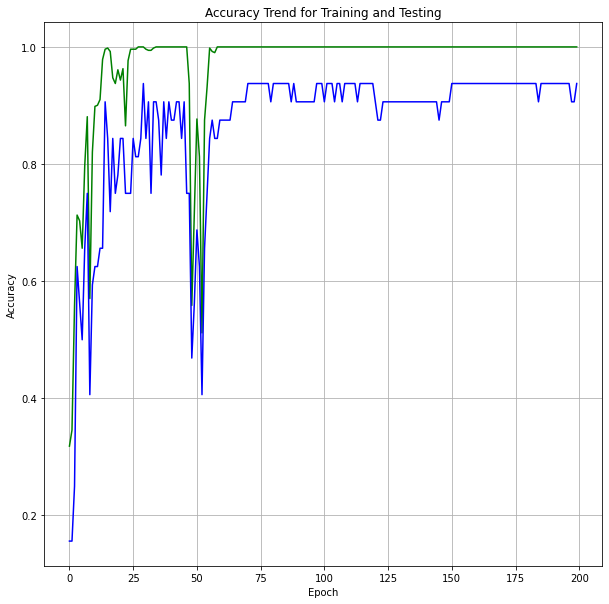

In [363]:
plt.title("Accuracy Trend for Training and Testing")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.plot(training_accuracy, 'g', label="Traning")
plt.plot(test_accuracy, 'b', label="Testing")
plt.show()

In [368]:
torch.save(cnn.state_dict(), "best_model_for_4_classes.pt")

## Prediction on Test Set

In [364]:
y_pred = torch.argmax(cnn(X_test.to(device)), dim=1)
y_pred

tensor([1, 1, 2, 3, 2, 3, 3, 1, 3, 3, 3, 0, 1, 2, 2, 2, 1, 0, 1, 1, 0, 0, 1, 3,
        3, 3, 2, 2, 3, 1, 2, 1], device='cuda:0')

# Model Evaluation

## Accuracy

In [365]:
accuracy(cnn, X_test, y_test, device)

tensor(0.9375, device='cuda:0')

## Precision & Recall

In [366]:
print(classification_report(y_test.cpu(), y_pred.cpu(), labels=None, target_names=['A', 'B', 'C', 'D'], digits=3))

              precision    recall  f1-score   support

           A      1.000     0.800     0.889         5
           B      0.800     1.000     0.889         8
           C      1.000     1.000     1.000         8
           D      1.000     0.909     0.952        11

    accuracy                          0.938        32
   macro avg      0.950     0.927     0.933        32
weighted avg      0.950     0.938     0.938        32



## Confusion Matrix

[[ 4  1  0  0]
 [ 0  8  0  0]
 [ 0  0  8  0]
 [ 0  1  0 10]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

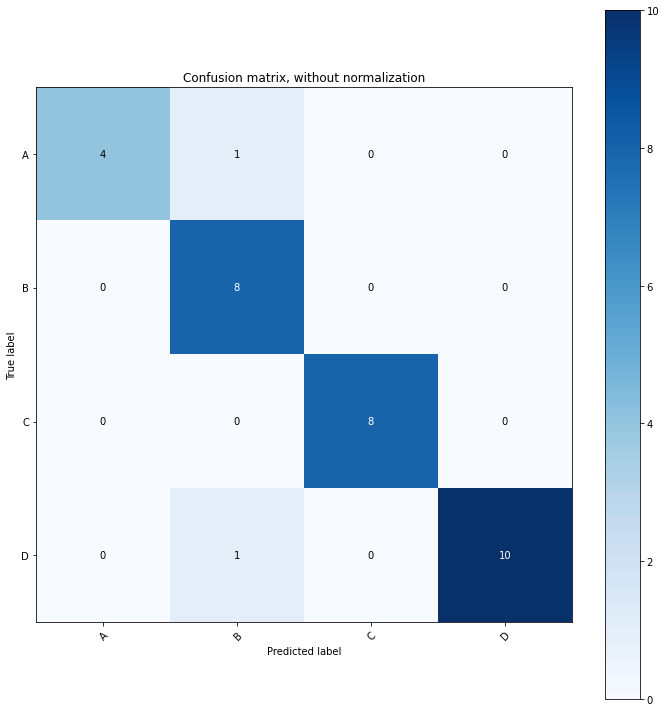

In [367]:
cm = confusion_matrix(y_test.cpu(), y_pred.cpu(), labels=None, sample_weight=None)
print(cm)
plt.rcParams["figure.figsize"] = (10,10)
plot_confusion_matrix(y_test.cpu(), y_pred.cpu(), classes=['A','B','C','D'], normalize=False)